In [ ]:
!pip install --extra-index-url https://pypi.netsquid.org netsquid

Looking in indexes: https://pypi.org/simple, https://pypi.netsquid.org
User for pypi.netsquid.org: mariochiaparini
Password: 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.1/276.1 kB 13.4 MB/s eta 0:00:00


In [ ]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import netsquid as ns
from netsquid.nodes.node import Node
from netsquid.nodes.connections import DirectConnection
from netsquid.components import ClassicalChannel, QuantumChannel,FibreLossModel
from netsquid.qubits import create_qubits
from netsquid.qubits.operators import *
from random import seed , randint
from netsquid.protocols import Protocol
from netsquid.components.models import FixedDelayModel, GaussianDelayModel, FibreDelayModel
import time
import matplotlib.pyplot as plt

In [ ]:
from scipy.linalg import expm
from numpy import random
from numpy.random import weibull
from itertools import combinations
from scipy.special import i0, i1
from netsquid.components.models.qerrormodels import QuantumErrorModel
from netsquid.qubits import qubitapi as qapi, QFormalism
from netsquid.qubits import operators as ops
from netsquid.qubits.operators import Operator, Z, I
import netsquid.util.simtools as simtools
from netsquid.util.simlog import warn_deprecated

In [ ]:
__all__ = [
    'FreeSpaceLossModel',
    'FixedSatelliteLossModel'
]

class FreeSpaceLossModel(QuantumErrorModel):
    """Model for photon loss on a free space channel

    Uses beam-wandering PDTC from [Vasylyev et al., PRL 108, 220501 (2012)] to
    sample the loss probability of the photon.

    Parameters
    ----------
    W0 : float
        Waist of the beam at the transmitter [m].
    rx_aperture : float
        Radius of the receiving telescope [m].
    Cn2 : float
        Index of refraction structure constant [m**(-2/3)].
    wavelength : float
        Wavelength of the radiation [m].
    Tatm : float
        Atmospheric transmittance (square of the transmission coefficient).
    sigmaPoint :
        Pointing error, standard deviation [rad].
    rng : :obj:`~numpy.random.RandomState` or None, optional
        Random number generator to use. If ``None`` then
        :obj:`~netsquid.util.simtools.get_random_state` is used.
    """
    def __init__(self, W0, rx_aperture, Cn2, wavelength, Tatm=1, sigmaPoint=0., rng=None):
        super().__init__()
        self.rng = rng if rng else simtools.get_random_state()
        self.W0 = W0
        self.rx_aperture = rx_aperture
        self.Cn2 = Cn2
        self.wavelength = wavelength
        self.sigmaPoint = sigmaPoint
        self.Tatm = Tatm
        self.required_properties = ['length']

    @property
    def rng(self):
        """ :obj:`~numpy.random.RandomState`: Random number generator."""
        return self.properties['rng']

    @rng.setter
    def rng(self, value):
        if not isinstance(value, np.random.RandomState):
            raise TypeError("{} is not a valid numpy RandomState".format(value))
        self.properties['rng'] = value

    @property
    def sigmaPoint(self):
        """ :float: pointing error at the transmitter [m]."""
        return self.properties['sigmaPoint']

    @sigmaPoint.setter
    def sigmaPoint(self, value):
        if value < 0:
            raise ValueError
        self.properties['sigmaPoint'] = value


    @property
    def Tatm(self):
        """ :float: atmosphere transmittance. """
        return self.properties['Tatm']

    @Tatm.setter
    def Tatm(self, value):
        if (value < 0) or (value > 1):
            raise ValueError
        self.properties['Tatm'] = value

    @property
    def W0(self):
        """float: beam waist at the transmitter [m]."""
        return self.properties['W0']

    @W0.setter
    def W0(self, value):
        if value < 0:
            raise ValueError
        self.properties['W0'] = value

    @property
    def rx_aperture(self):
        """float: radius of the receiving telescope [m]."""
        return self.properties['rx_aperture']

    @rx_aperture.setter
    def rx_aperture(self, value):
        if value < 0:
            raise ValueError
        self.properties['rx_aperture'] = value

    @property
    def Cn2(self):
        """float: index of refraction structure constant [m**(-2/3)]."""
        return self.properties['Cn2']

    @Cn2.setter
    def Cn2(self, value):
        if value < 0:
            raise ValueError
        self.properties['Cn2'] = value

    @property
    def wavelength(self):
        """float: wavelength of the radiation [m]."""
        return self.properties['wavelength']

    @wavelength.setter
    def wavelength(self, value):
        if value < 0:
            raise ValueError
        self.properties['wavelength'] = value

    def _compute_weibull_loss_model_parameters(self, length):
        """ Compute the parameters of the Weibull model

        This function calculates the parameters of the Weibull distribution
        lambda and R, described in equations (6) and (7) of [Vasylyev et al.,
        PRL 108, 220501 (2012)], and the maximal transmission T0, described in
        equation (5) of the same reference.

        It then converts these parameters to the parameters a and scaleL
        required by numpy to sample the Weibull distribution.

        Parameters
        ----------
        length: float
            Length of the channel.

        Returns
        -------
        tuple (float, float, float)
            The elements of the tuple are properties of the
            Weibull distribution. From left to right:
            - the 'shape' parameter
            - the 'scale' parameter
            - 'T0'
        """

        z = length*1e3
        W = self.W0*np.sqrt(1 + (z*self.wavelength/(np.pi*self.W0**2))**2)
        X = (self.rx_aperture/W)**2
        T0 = np.sqrt(1 - np.exp(-2*X))
        sigmaTurb = np.sqrt(1.919 * self.Cn2 * z**3 * (2*self.W0)**(-1./3.))
        sigma = np.sqrt( (self.sigmaPoint*z)**2 + sigmaTurb**2 )
        l = 8 * X * np.exp(-4*X) * i1(4*X) / (1 - np.exp(-4*X)*i0(4*X)) / np.log( 2*T0**2/(1-np.exp(-4*X)*i0(4*X)))
        R = self.rx_aperture * np.log( 2*T0**2/(1-np.exp(-4*X)*i0(4*X)) )**(-1./l)

        # define the parameters of the Weibull distribution
        a = 2/l
        scaleL = (2*(sigma/R)**2)**(l/2)

        return (a, scaleL, T0)

    def _sample_loss_probability(self, length):
        """ Sample the loss probability distribution

        This function samples the Weibull distribution to get the value of the
        channel transmittance, using the parameters calculated in the
        _compute_weibull_loss_model_parameter method.

        It uses the numpy.weibull method to implement the sampling of the
        probability distribution described in equation (9) of [Vasylyev et al.,
        PRL 108, 220501 (2012)].

        Parameters
        ----------
        length: float
            Length of the channel [km].

        Returns
        -------
        float
        """
        a, scaleL, T0 = self._compute_weibull_loss_model_parameters(length=length)

        # extract the value of the transmission coefficient
        x = weibull(a, 1)
        scaleX = scaleL * x
        T = T0*np.exp(-scaleX/2)
        # calculate the probability of losing the qubit
        prob_loss = 1 - self.Tatm * T**2
        return prob_loss

    def error_operation(self, qubits, delta_time=0, **kwargs):
        """Error operation to apply to qubits.

        Parameters
        ----------
        qubits : tuple of :obj:`~netsquid.qubits.qubit.Qubit`
            Qubits to apply noise to.
        delta_time : float, optional
            Time qubits have spent on a component [ns].

        """
        if 'channel' in kwargs:
            warn_deprecated("channel parameter is deprecated. "
                            "Pass length parameter directly instead.",
                            key="FreeSpaceLossModel.compute_model.channel")
            kwargs['length'] = kwargs['channel'].properties["length"]
            del kwargs['channel']


        for idx, qubit in enumerate(qubits):
            if qubit is None:
                continue
            prob_loss = self._sample_loss_probability(length=kwargs['length'])
            self.lose_qubit(qubits, idx, prob_loss, rng=self.properties['rng'])


class FixedSatelliteLossModel(FreeSpaceLossModel):
    """Model for photon loss on a satellite-to-ground static channel

    Uses beam-wandering PDTC from [Vasylyev et al., PRL 108, 220501 (2012)] to
    sample the loss probability of the photon.

    Parameters
    ----------
    txDiv : float
        Divergence of the beam sent from the satellite [rad].
    sigmaPoint :
        Pointing error of the satellite, standard deviation [rad].
    rx_aperture : float
        Radius of the receiving telescope [m].
    Cn2 : float
        Index of refraction structure constant [m**(-2/3)].
    wavelength : float
        Wavelength of the radiation [m].
    Tatm : float
        Atmospheric transmittance (square of the transmission coefficient).
    rng : :obj:`~numpy.random.RandomState` or None, optional
        Random number generator to use. If ``None`` then
        :obj:`~netsquid.util.simtools.get_random_state` is used.
    """
    def __init__(self, txDiv, sigmaPoint, rx_aperture, Cn2, wavelength, Tatm=1, rng=None):
        super().__init__(wavelength/(np.pi*txDiv),rx_aperture,Cn2,wavelength,Tatm,sigmaPoint,rng)
        self.txDiv = txDiv
        self.required_properties = ['length']

    @property
    def txDiv(self):
        """float: divergence of the beam at the transmitter (satellite) [m]."""
        return self.properties['txDiv']

    @txDiv.setter
    def txDiv(self, value):
        if value < 0:
            raise ValueError
        self.properties['txDiv'] = value

    def _compute_weibull_loss_model_parameters(self, length):
        """Compute the parameters of the Weibull model

        This function calculates the parameters of the Weibull distribution
        lambda and R, described in equations (6) and (7) of [Vasylyev et al.,
        PRL 108, 220501 (2012)], and the maximal transmission T0, described in
        equation (5) of the same reference.

        It then converts these parameters to the parameters a and scaleL
        required by numpy to sample the Weibull distribution.

        Parameters
        ----------
        length: float
            Length of the channel.

        Returns
        -------
        tuple (float, float, float)
            The elements of the tuple are properties of the
            Weibull distribution. From left to right:
            - the 'shape' parameter
            - the 'scale' parameter
            - 'T0'
        """

        # this function cannot be used for range values lower than 10 km
        if length <= 10:
            raise ValueError

        z = length*1e3
        W = self.txDiv * z
        X = (self.rx_aperture/W)**2
        T0 = np.sqrt(1 - np.exp(-2*X))
        sigmaTurb = np.sqrt(1.919 * self.Cn2 * 10e3**3 * (2*self.txDiv*(z-10e3))**(-1./3.))
        sigma = np.sqrt( (self.sigmaPoint*z)**2 + sigmaTurb**2 )
        l = 8 * X * np.exp(-4*X) * i1(4*X) / (1 - np.exp(-4*X)*i0(4*X)) / np.log( 2*T0**2/(1-np.exp(-4*X)*i0(4*X)))
        R = self.rx_aperture * np.log( 2*T0**2/(1-np.exp(-4*X)*i0(4*X)) )**(-1./l)

        # define the parameters of the Weibull distribution
        a = 2/l
        scaleL = (2*(sigma/R)**2)**(l/2)

        return (a, scaleL, T0)

'''

a: Random Number between 0 and 3
0: |0> state (default)
1: |1> state (apply single-qubit Pauli-X gate to |0>)
2: |+> state (apply Hadamard gate to |0>)
3: |-> state (apply single-qubit Pauli-X gate and Hadamard gate to |0>)

'''

In [ ]:
# Measures randomly in the Standard or Hadamard basis
def random_ZX_measure(num_bits, qlist):
    seed(randint(0, 2 ** num_bits))
    opList = [2] * num_bits
    loc_res_measure = [2] * num_bits
    for q in qlist:
        rbit = randint(0, 1)
        a = int(q.name[1:])
        opList[a] = rbit
        if rbit == 0:
            loc_res_measure[a] = ns.qubits.qubitapi.measure(q, observable = Z) #measure in standard basis
        elif rbit == 1:
            loc_res_measure[a] = ns.qubits.qubitapi.measure(q, observable = X) #measure in Hadamard basis
        else:
            print("measuring ERROR!!\n")
    return opList,loc_res_measure

In [ ]:
# Match measures between Alice and Bob
def Compare_measurement(num_bits, stateList, opList):
    matchList = []
    for i in range(0, num_bits):
        if stateList[i] < 2 and opList[i] == 0:    #measure in standard basis
            matchList.append(i)
        elif stateList[i] >= 2 and opList[i] == 1: #measure in Hadamard basis
            matchList.append(i)
        else:
            pass
    return matchList

In [ ]:

# Create random qubits - Starting the BB84 Protocol
def create_random_qubits(num_bits, v):
    seed(randint(0, 4 ** num_bits))
    res_state = []
    qlist = []
    qlist = create_qubits(num_bits, system_name = "Q")
    for i in range(0, num_bits):
        res_state.append(randint(0,3))
    det = []
    '''
        a: Random Number between 0 and 3
           0: |0> state (default)
           1: |1> state (apply single-qubit Pauli-X gate to |0>)
           2: |+> state (apply Hadamard gate to |0>)
           3: |-> state (apply single-qubit Pauli-X gate and Hadamard gate to |0>)
    '''
    for a, b in zip(res_state, qlist):
        if a == 0:
            det.append("0")
            pass
        elif a == 1:
            ns.qubits.operate(b, ns.X)
            det.append("1")
        elif a == 2:
            ns.qubits.operate(b, ns.H)
            det.append("+")
        elif a == 3:
            ns.qubits.operate(b, ns.X)
            ns.qubits.operate(b, ns.H)
            det.append("-")
        else:
            print("Create random bits ERROR!!")
    if v: # for verbose
        print("Alice Random Qubits: ", det, str(len(det)) + " Qubits")
    return res_state, qlist

In [ ]:
class BB84(Protocol):

    def BB84_Alice_sendQubits(self):
        self.stateList,qlist = create_random_qubits(self.num_bits, self.v)
        self.node_A.ports["portQA"].tx_output(qlist)

    def BB84_Bob_measure_send(self, qlist):
        qlist = qlist.items
        if isinstance(qlist[0], int):
            pass
        else:
            # B measuring
            B_basis, self.res_measure = random_ZX_measure(self.num_bits, qlist)
            det = []
            for el in B_basis:
                if el == 0:
                    det.append('0')
                else:
                    det.append('+')
            if B_basis == -1:
                print("B measuring failed!!")
            else :

                if self.v:
                    print("Bob get: ", qlist)
                    print("Bob measure: ", det)
                self.portCB.tx_output(B_basis)

    def BB84_Alice_measure_send_keygen(self, opList):
        opList = opList.items

        matchList = Compare_measurement(self.num_bits, self.stateList, opList)


        self.portCA.tx_output(matchList)

        for i in matchList:
            self.key_A.append(self.stateList[i] % 2)
        if self.v:
            print("Alice get: ", opList)

        return self.key_A

    def BB84_Bob_keygen(self, matchList):
        matchList = matchList.items

        for i in matchList:
            self.key_B.append(self.res_measure[int(i)][0])
        if self.v:
            print("Bob Shared Key: ",self.key_B)
        return self.key_B

    def __init__(self, num_bits=8, fibre_len=10e-6, txDiv=10e-6, sigmaPoint=0.5e-8, rx_aperture_sat=1, Cn2_sat=1e-15, wavelength=1550e-9):
        super().__init__()
        self.node_A = Node("A",ID = 0, port_names=["portQA","portCA"])
        self.node_B = Node("B",ID = 1, port_names=["portQB","portCB"])
        self.portCB = self.node_B.ports["portCB"]
        self.portCA = self.node_A.ports["portCA"]
        self.MyQfiber = None
        self.MyCfiber = None
        self.num_bits = num_bits
        self.stateList = None
        self.res_measure = None
        self.key_A = []
        self.key_B = []
        self.txDiv = txDiv
        self.sigmaPoint = sigmaPoint
        self.rx_aperture_sat = rx_aperture_sat
        self.Cn2_sat = Cn2_sat
        self.wavelength = wavelength
        self.v = False
        self.fiberLenth = fibre_len
        #self.fibre_loss_init = fibre_loss_init
        #self.fibre_loss_length = fibre_loss_length
        #self.v = v
        self.start()

    def stop(self):
        super().stop()
        self._running = False

    def is_connected():
        super().is_connected()
        pass

    def start(self):
        super().start()
        ### Satellite to Ground channel parameters

        self.MyQfiber = QuantumChannel("QFibre_A->B",
                                       length=self.fiberLenth,
                                       loss_model=FixedSatelliteLossModel(
                                           txDiv=self.txDiv,
                                           sigmaPoint=self.sigmaPoint,
                                           rx_aperture=self.rx_aperture_sat,  # Renamed parameter
                                           Cn2=self.Cn2_sat,                   # Renamed parameter
                                           wavelength=self.wavelength),depolar_rate=1e2, noise_model="default")
        self.MyCfiber = DirectConnection("CFibreConn_A->B",
            ClassicalChannel("CFibre_A->B", length = self.fiberLenth),
            ClassicalChannel("CFibre_B->A", length = self.fiberLenth))

        self.node_A.connect_to(self.node_B, self.MyQfiber,
            local_port_name="portQA", remote_port_name="portQB")

        self.node_B.connect_to(self.node_A, self.MyCfiber,
            local_port_name="portCB", remote_port_name="portCA")

        self.node_B.ports["portQB"].bind_input_handler(self.BB84_Bob_measure_send)
        self.node_A.ports["portCA"].bind_input_handler(self.BB84_Alice_measure_send_keygen)
        self.node_B.ports["portCB"].bind_input_handler(self.BB84_Bob_keygen)
        self.BB84_Alice_sendQubits()

In [ ]:
def run_BB84_sim(runtimes = 1, num_bits = 300, fibre_len = 10**-6, fibre_loss_init = 0.2,fibre_loss_length = 0.25, verbose = False):
  ns.sim_reset()
  run_times = runtimes
  MyBB84List = []  # Resulted keys in the QKD
  for i in range(run_times):
    MyBB84List.append(BB84(num_bits,fibre_len,fibre_loss_init,fibre_loss_length, verbose).key_B)
  ns.sim_run()
  return MyBB84List

## Skyfield

In [ ]:
!pip install skyfield

In [ ]:
import skyfield.api
from skyfield.api import load, wgs84, Loader
from skyfield.api import Topos, utc
from skyfield.sgp4lib import EarthSatellite
from skyfield.constants import AU_KM, DAY_S
from skyfield.functions import length_of
from skyfield.functions import length_of
from skyfield.positionlib import ICRF
from datetime import datetime, timedelta

In [ ]:
load = Loader('./skyfield-data')
eph = load('de421.bsp')
ITRF = wgs84
earth = {
    'geoid': wgs84,
    'radius_m': wgs84.radius.m,
    'flattening': wgs84.inverse_flattening,
    'polar_radius': wgs84.polar_radius.m
}

In [ ]:
start_starlink = datetime(2023, 2, 12, 9, 0, 0)
end_starlink = datetime(2023, 2, 12, 10, 0, 0)

start_amazon = datetime(2024, 10, 22, 13, 0, 0)
end_amazon = datetime(2024, 10, 22, 14, 20)

start_iridium = datetime(2024, 2, 16, 6, 40, 0)
end_iridium = datetime(2024, 2, 16, 7, 20)

start_starlink_1008 = datetime(2024, 10, 25, 7, 30, 0)
end_starlink_1008 = datetime(2024, 10, 25, 8, 30)

Step = timedelta(seconds = 1.)

In [ ]:
lat_unicamp = -22.8542
lon_unicamp = -47.0220
alt_unicamp = 0.

In [ ]:
class Satellite:
  def __init__(self, tle='', simType='tle', incAngle=0, satAlt=0):
    self.simType = simType
    self.ts = load.timescale()
    self.satellite = load('de421.bsp')

    if simType == 'tle':

      self.tleList = tle
      self.tleObject = EarthSatellite(self.tleList[0],
                                     self.tleList[1],
                                     name="sat",
                                     ts=load.timescale())
      #self.t = t
      #self.position = self.propagator.position.km
      #self.velocity = self.propagator.velocity.km_per_s
      self.simType = 'tle'

    elif simType == 'polOrbPass':

      self.incAngle = radians(incAngle)
      self.satAlt = satAlt
      #self.t = t
      self.propagator = self.satellite.at()
      self.position = self.propagator.position.km
      self.velocity = self.propagator.velocity.km_per_s
      self.simType = 'polOrbPass'

    else:
      self.simType = ' '

    def setSimTLE(self, tle):
      self.tleList = tle
      self.tleObject = EarthSatellite(tle[0], tle[1], eph)
      self.propagator = self.tleOject.at()
      self.position = self.propagator.position.km
      self.velocity = self.propagator.velocity.km_per_s
      self.simType = 'tle'
      return self.position, self.velocity

In [ ]:
class DownChannel:
  def __init__(self, tle, lat, lon, alt, wl=None, atmModel=None):
    self.latitude = lat
    self.longitude = lon
    self.altitude = alt
    self.tle = tle

    #self.wavelength = float(wl)

  def calculateParameters(self, start, end, step):

    ts = load.timescale(builtin=True)
    timelist = []
    run_times=5
    num_bits=200
    name, L1, L2 = self.tle.splitlines()
    sat = EarthSatellite(L1, L2)

    while start < end:
      timelist.append(start)
      start += step

    distance = np.zeros( (len(timelist),) )
    elevation = np.zeros( (len(timelist),) )
    qkd = np.zeros( (len(timelist),) )

    for i in range(len(timelist)):

      t = ts.utc(timelist[i].year, timelist[i].month,
      timelist[i].day,timelist[i].hour,
      timelist[i].minute,timelist[i].second)

      ground_station = wgs84.latlon(self.latitude, self.longitude, self.altitude)
      diff = sat - ground_station

      alt, az, dist = diff.at(t).altaz()

      elevation[i] = alt.degrees
      distance[i] = dist.km

      x_axis = []

      if elevation[i] > 0:
        key_sum = 0.0
        x_axis.append(1.*distance[i])
        key_list = run_BB84_sim(run_times,num_bits,1.*distance[i])

        for j in key_list:
          key_sum = key_sum + len(j)

        qkd[i] = key_sum/run_times

    return distance, elevation, qkd

In [ ]:
tle_AMAZONIA_1 = '''
1 47699U 21015A   24331.66896108  .00000823  00000+0  27046-3 0  9995
2 47699  98.3819  44.8584 0001784 110.4232 249.7148 14.40820713196923
'''
tle_STARLINK_2071 = """
1 48656U 21044U   24339.55275590  .00026086  00000+0  17641-2 0  9991
2 48656  53.0534  27.2526 0001973  90.0742 270.0473 15.06391245194358
"""
tle_IRIDIUM_122 = """
1 42957U 17061C   25007.49702594  .00000117  00000+0  34556-4 0  9991
2 42957  86.3957 244.8288 0001777  86.7983 273.3416 14.34214161379435
"""
tle_STARLINK_1008 = '''
1 44714U 19074B   25012.00402021  .00004094  00000+0  29358-3 0  9996
2 44714  53.0539 279.6404 0001242  80.1545 279.9584 15.06395110285360
'''

In [ ]:
down_channel = DownChannel(tle_IRIDIUM_122, lat_unicamp, lon_unicamp, alt_unicamp)
distance, elevation, qkd  = down_channel.calculateParameters(start_iridium, end_iridium, Step)

In [ ]:
def plot_BB84():
  y_axis, x_axis =[], []
  run_times=10
  num_bits=10
  for idx,dist, elev in zip(range(len(distance)), distance, elevation):
    if elev > 0:
      key_sum=0.0
      x_axis.append(1.*dist)
      key_list=run_BB84_sim(run_times,num_bits,1.*dist)

      for j in key_list:
        key_sum=key_sum+len(j)

      y_axis.append(key_sum/run_times)

      plt.scatter(x_axis, y_axis)
      plt.show()
      #plt.plot(x_axis, y_axis, 'go-',label='FibreLossModel1')
      #plt.plot(x_axis, [np.mean(y_axis)]*len(y_axis), linestyle='--', label = "Mean1")
      #plt.show()


In [ ]:
len(qkd)

2400

In [ ]:
#qkd higher then zero
qkd_values = [i for i in qkd if i > 0]

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
#smoothing signal
from scipy.signal import savgol_filter

In [ ]:
#lets smooth the qkd values
qkd_smooth = savgol_filter(qkd, 50, 10)

In [ ]:
qkd_smooth_values = [i for i in qkd_smooth if i > 0]

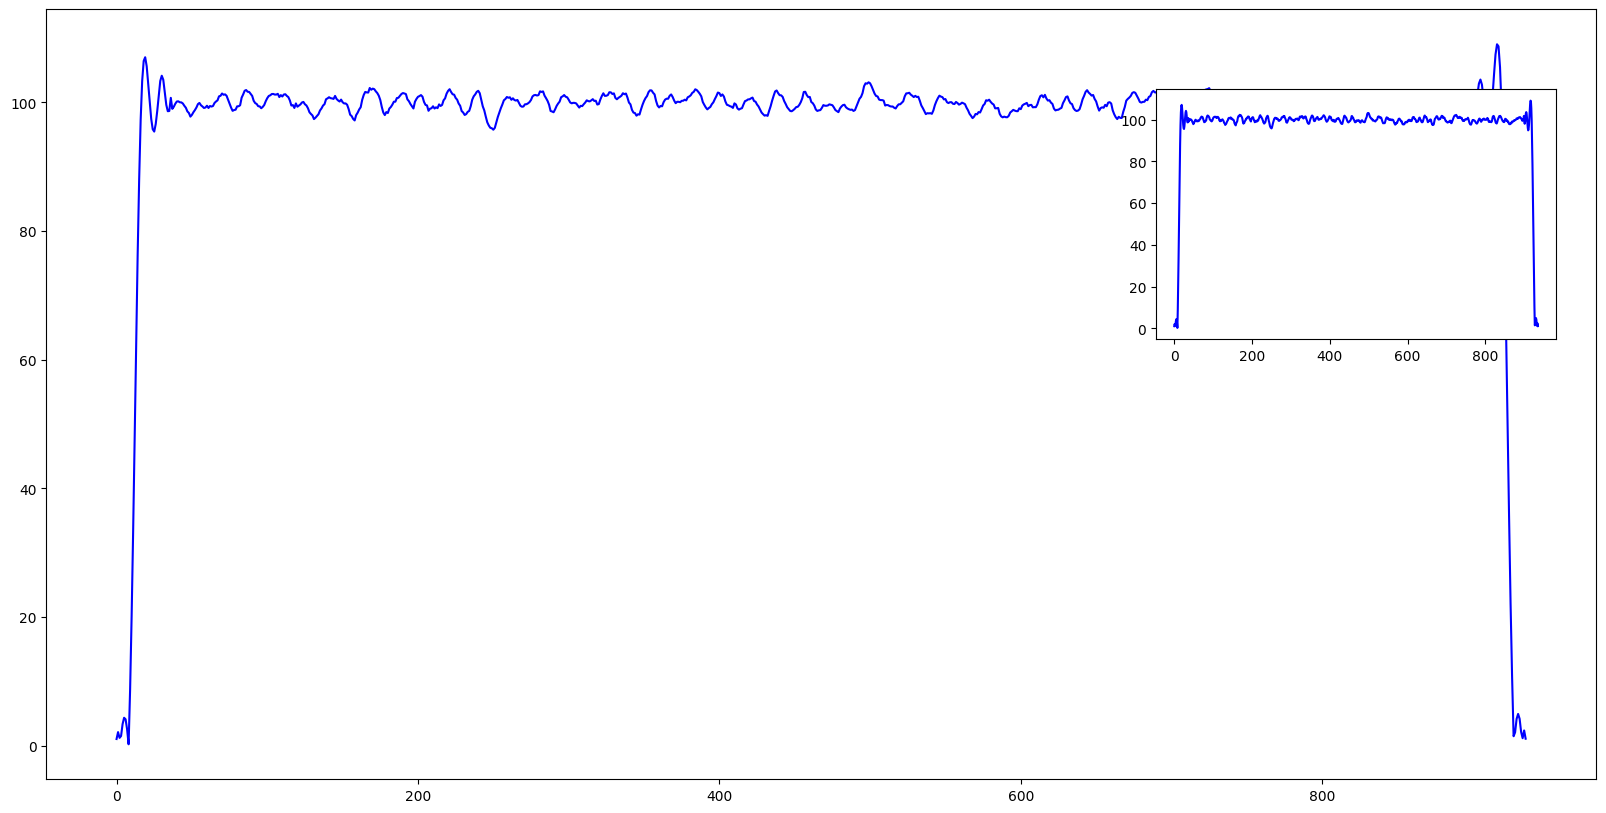

In [ ]:
# plot the main figure
plt.figure(figsize=(20, 10))

plt.plot(qkd_smooth_values, c = 'b')

 # location for the zoomed portion
sub_axes = plt.axes([.68, .55, .20, .25])

# plot the zoomed portion
sub_axes.plot(qkd_smooth_values, c = 'b')

# insert the zoomed figure
# plt.setp(sub_axes)

plt.show()

## **Multiple Satellite**

In [ ]:
tle_list = [
    (tle_AMAZONIA_1, 'Amazonia'),
    (tle_STARLINK_2071, 'Starlink2071'),
    (tle_IRIDIUM_122, 'Iridium122'),
    (tle_STARLINK_1008, 'Starlink1008')
]

In [ ]:
start_list = [start_amazon, start_starlink, start_iridium, start_starlink_1008]
end_list = [end_amazon, end_starlink, end_iridium, end_starlink_1008]

In [ ]:
colors = ['b', 'g', 'r', 'm']

<ipython-input-69-79b81c07b36a>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


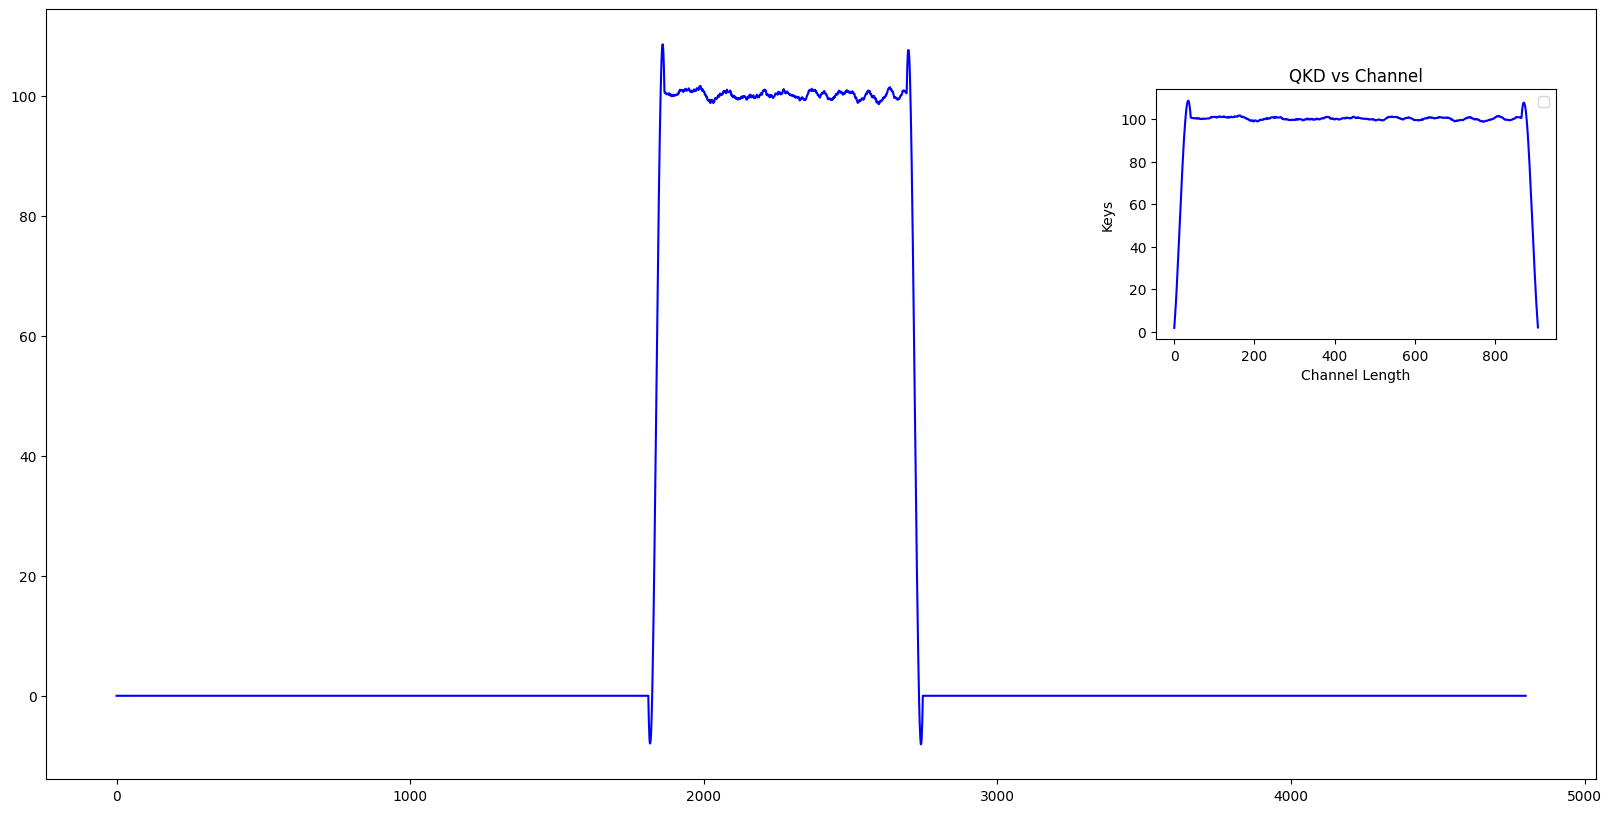

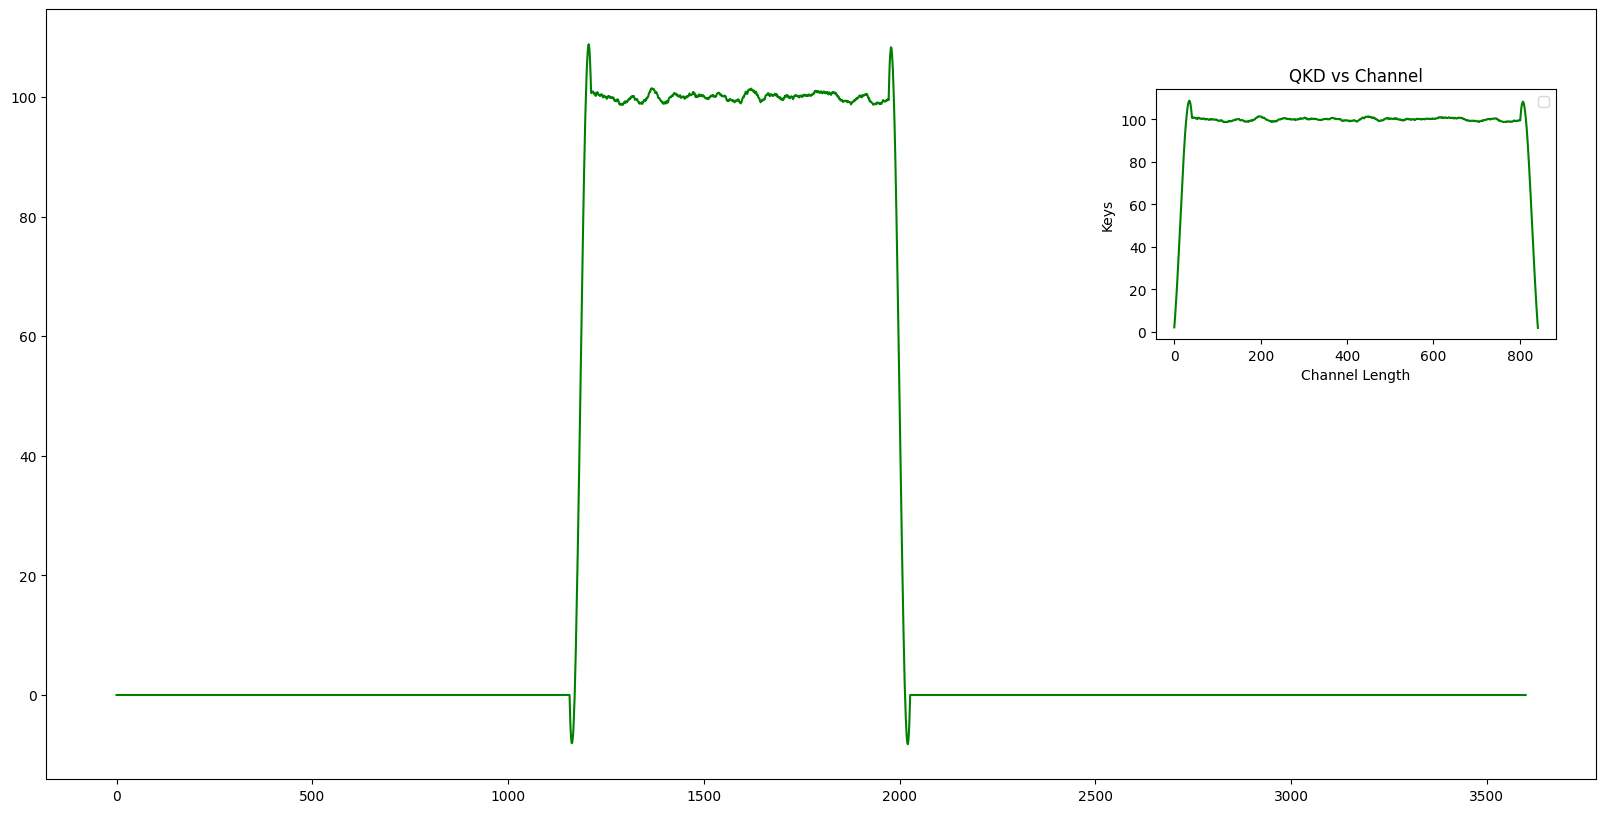

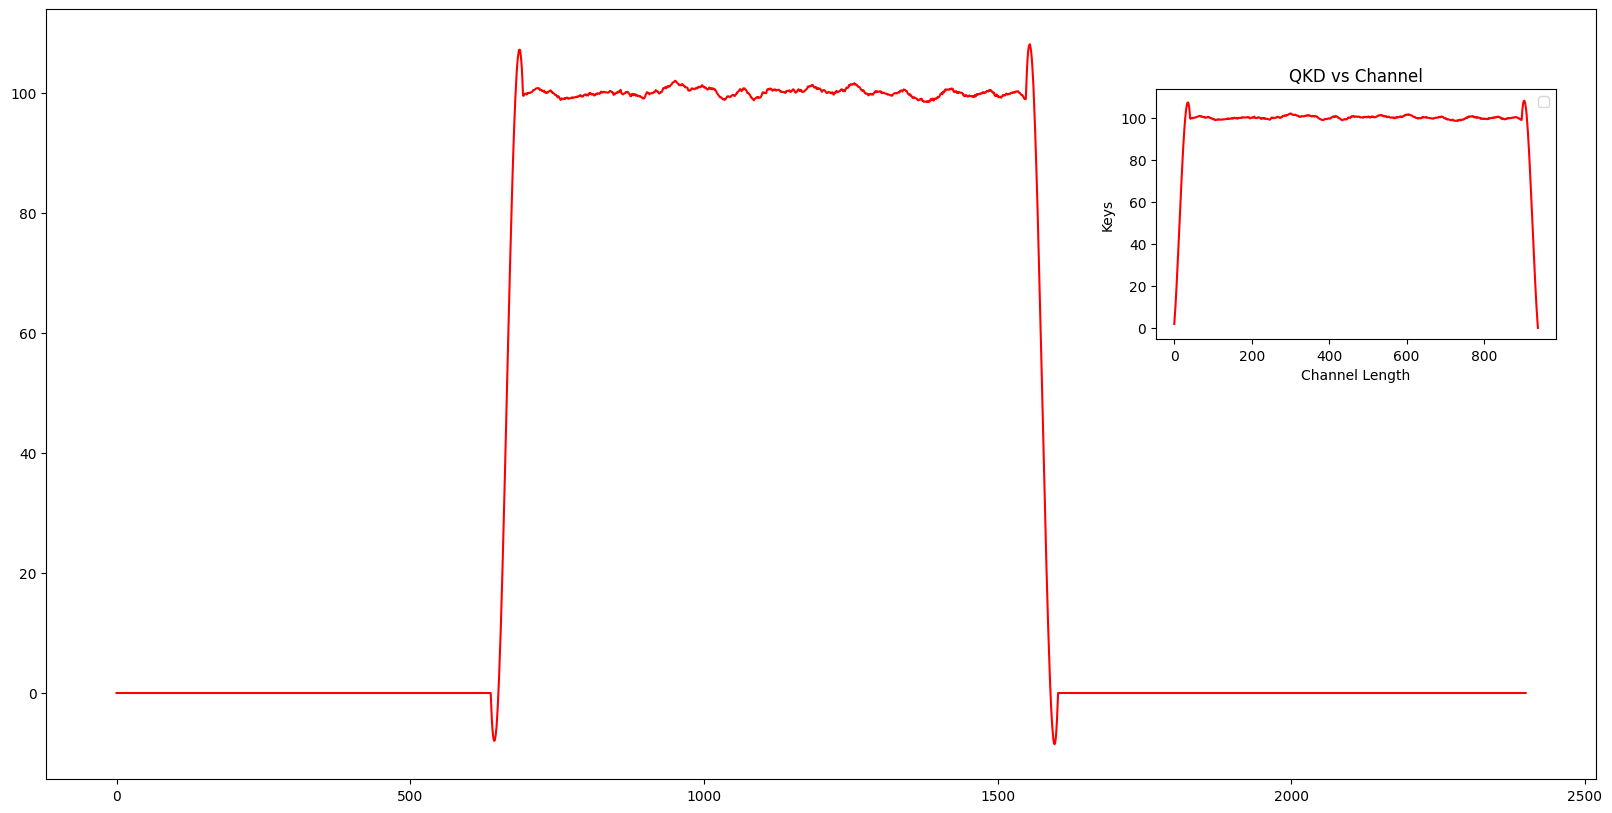

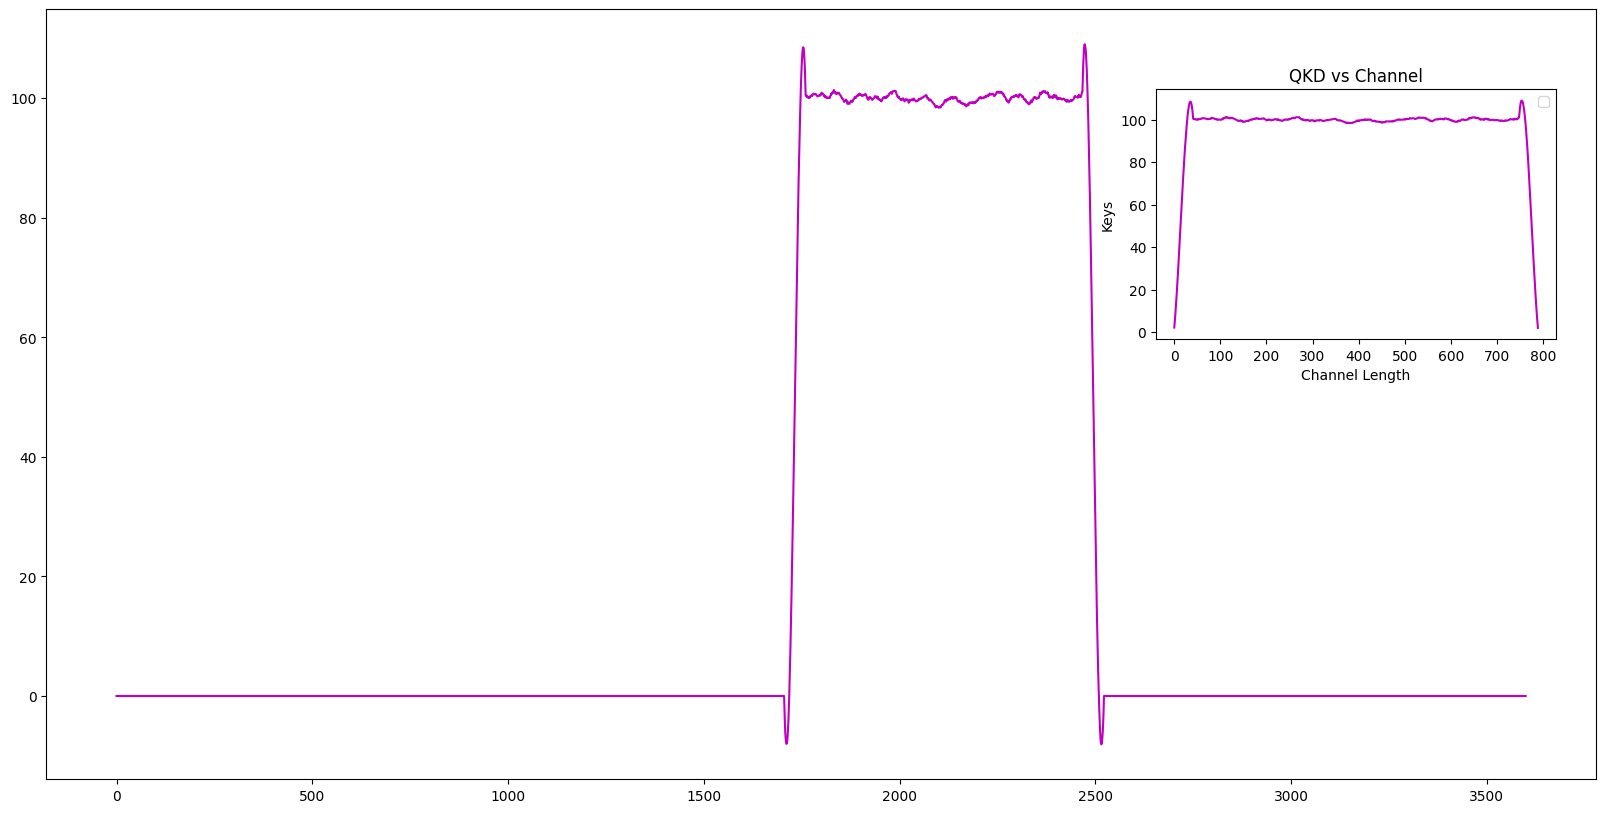

In [ ]:
for (tle, label), color, start, end in zip(tle_list, colors, start_list, end_list):
  down_channel = DownChannel(tle, lat_unicamp, lon_unicamp, alt_unicamp)
  distance, elevation, qkd  = down_channel.calculateParameters(start, end, Step)
  qkd_smooth = savgol_filter(qkd, 55, 2, mode='nearest')
  qkd_smooth_value = [i for i in qkd_smooth if i > 0]

  plt.figure(figsize=(20, 10))#

  plt.plot(qkd_smooth, color=color, label=label)
  sub_axes = plt.axes([.68, .55, .20, .25])
  sub_axes.plot(qkd_smooth_value, color=color)
  plt.title('QKD vs Channel')
  plt.xlabel('Channel Length')
  plt.ylabel('Keys')
  plt.legend()
  plt.show()

In [ ]:
import pandas as pd

In [ ]:
qkd_amazon = []
qkd_starlink_2071 = []
qkd_iridium = []
qkd_starlink_1008 = []

In [ ]:
for (tle, label), color, start, end in zip(tle_list, colors, start_list, end_list):
  down_channel = DownChannel(tle, lat_unicamp, lon_unicamp, alt_unicamp)
  distance, elevation, qkd  = down_channel.calculateParameters(start, end, Step)
  qkd_smooth = savgol_filter(qkd, 55, 2, mode='nearest')
  qkd_smooth_value = [i for i in qkd_smooth if i > 0]
  if label == 'Amazonia':
    print()
    qkd_amazon = qkd
  elif label == 'Starlink2071':
    qkd_starlink_2071 = qkd
  elif label == 'Iridium122':
    qkd_iridium = qkd
  elif label == 'Starlink1008':
    qkd_starlink_1008 = qkd
  else:
    print('error')

In [ ]:
#maiores que 0
qkd_amazon_values = [i for i in qkd_amazon if i > 0]
qkd_starlink_2071_values = [i for i in qkd_starlink_2071 if i > 0]
qkd_iridium_values = [i for i in qkd_iridium if i > 0]
qkd_starlink_1008_values = [i for i in qkd_starlink_1008 if i > 0]

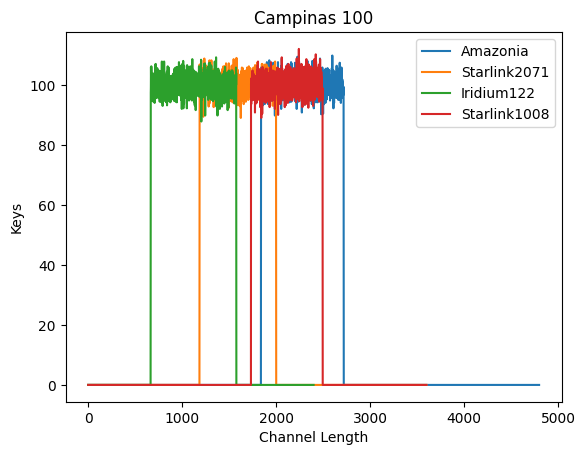

In [ ]:
plt.plot(qkd_amazon, label='Amazonia')
plt.plot(qkd_starlink_2071, label='Starlink2071')
plt.plot(qkd_iridium, label='Iridium122')
plt.plot(qkd_starlink_1008, label='Starlink1008')
plt.title('Campinas 100')
plt.xlabel('Channel Length')
plt.ylabel('Keys')
plt.legend()

In [ ]:
colors = ['peachpuff', 'orange', 'blue', 'green']

labels = ['Iridium122', 'Starlink2071', 'Amazonia', 'Starlink1008']

<Figure size 2000x1000 with 0 Axes>

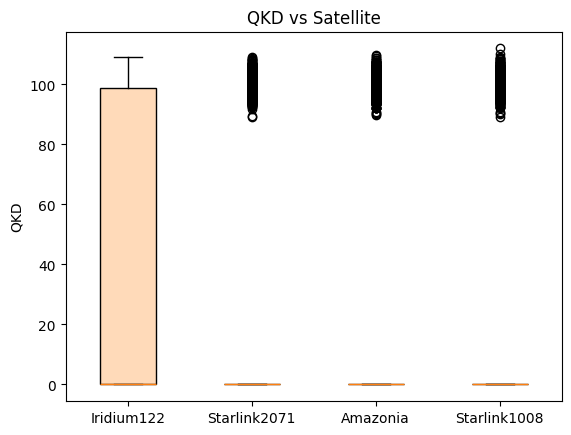

In [ ]:
# box plot qkd by each satellite same chart
plt.figure(figsize=(20, 10))
#plt.boxplot([qkd_iridium, qkd_starlink_2071, qkd_amazon, qkd_starlink_1008])
#plt.xticks([1, 2, 3, 4], ['Iridium122', 'Starlink2071', 'Amazonia', 'Starlink1008'])
fig, ax = plt.subplots()
bplot = ax.boxplot([qkd_iridium, qkd_starlink_2071, qkd_amazon, qkd_starlink_1008], patch_artist=True)
for patch, color, label in zip(bplot['boxes'], colors, labels):
  patch.set_facecolor(color)
plt.xticks([1, 2, 3, 4], ['Iridium122', 'Starlink2071', 'Amazonia', 'Starlink1008'])
plt.title('QKD vs Satellite')
plt.ylabel('QKD')
plt.show()

## UFPA

In [ ]:
lat_ufpa = -1.4677
lon_ufpa = -48.4435
alt_ufpa = 0.

In [ ]:
start_starlink = datetime(2023, 2, 12, 9, 0, 0)
end_starlink = datetime(2023, 2, 12, 10, 0, 0)

#2024-10-24 13:51:58

start_amazon = datetime(2024, 10, 24, 13, 0, 0)
end_amazon = datetime(2024, 10, 24, 14, 40, 0)

#2024-10-24 13:45:43

start_iridium = datetime(2024, 2, 16, 6, 30, 0)
end_iridium = datetime(2024, 2, 16, 7, 20)

start_starlink_1008 = datetime(2024, 10, 25, 7, 30, 0)
end_starlink_1008 = datetime(2024, 10, 25, 8, 30)

In [ ]:
down_1 = DownChannel(tle_AMAZONIA_1, lat=lat_ufpa, lon=lon_ufpa,alt=alt_ufpa)
down_starlink = DownChannel(tle_STARLINK_2071, lat=lat_ufpa, lon=lon_ufpa,alt=alt_ufpa)
down_iridium = DownChannel(tle_IRIDIUM_122, lat=lat_ufpa, lon=lon_ufpa,alt=alt_ufpa)
down_starlink_1008 = DownChannel(tle_STARLINK_1008, lat=lat_ufpa, lon=lon_ufpa,alt=alt_ufpa)

In [ ]:
dist_IRIDIUM, elev_IRIDIUM, qkd_IRIDIUM = down_iridium.calculateParameters(start_iridium, end_iridium, Step)
dist_AMAZONIA, elev_AMAZONIA, qkd_AMAZONIA = down_1.calculateParameters(start_amazon, end_amazon, Step)
dist_STARLINK, elev_STARLINK, qkd_STARLINK = down_starlink.calculateParameters(start_starlink, end_starlink, Step)
dist_STARLINK_1008, elev_STARLINK_1008, qkd_STARLINK_1008 = down_starlink_1008.calculateParameters(start_starlink_1008, end_starlink_1008, Step)

<ipython-input-31-a344ae5ec003>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


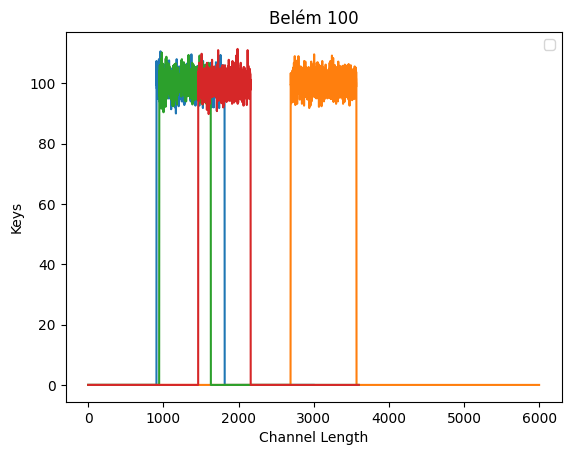

In [ ]:
plt.plot(qkd_IRIDIUM)
plt.plot(qkd_AMAZONIA)
plt.plot(qkd_STARLINK)
plt.plot(qkd_STARLINK_1008)
plt.title('QKD vs Channel')
plt.title('Belém 100')
plt.xlabel('Channel Length')
plt.ylabel('Keys')
plt.legend()

In [ ]:
#smoothe
qkd_IRIDIUM_smooth = savgol_filter(qkd_IRIDIUM, 55, 2, mode='nearest')
qkd_AMAZONIA_smooth = savgol_filter(qkd_AMAZONIA, 55, 2, mode='nearest')
qkd_STARLINK_smooth = savgol_filter(qkd_STARLINK, 55, 2, mode='nearest')
qkd_STARLINK_1008_smooth = savgol_filter(qkd_STARLINK_1008, 55, 2, mode='nearest')

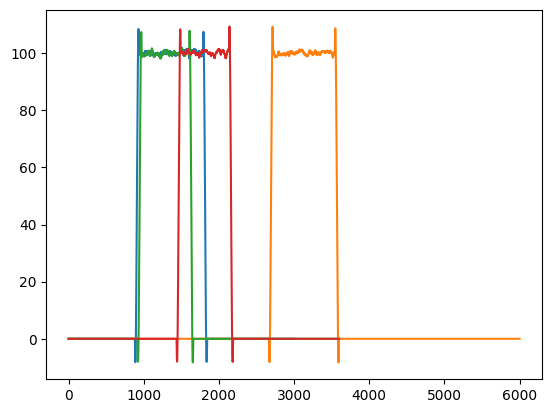

In [ ]:
plt.plot(qkd_IRIDIUM_smooth)
plt.plot(qkd_AMAZONIA_smooth)
plt.plot(qkd_STARLINK_smooth)
plt.plot(qkd_STARLINK_1008_smooth)

In [ ]:
qkd_smooth_value_IRIDIUM = [i for i in qkd_IRIDIUM_smooth if i > 0]
qkd_smooth_value_AMAZONIA = [i for i in qkd_AMAZONIA_smooth if i > 0]
qkd_smooth_value_STARLINK = [i for i in qkd_STARLINK_smooth if i > 0]
qkd_smooth_value_STARLINK_1008 = [i for i in qkd_STARLINK_1008_smooth if i > 0]

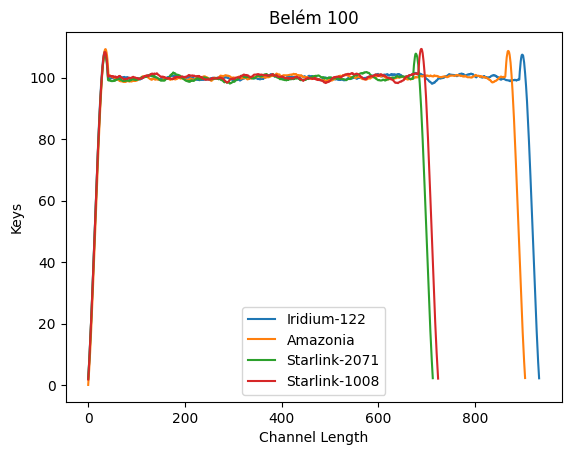

In [ ]:
plt.plot(qkd_smooth_value_IRIDIUM, label="Iridium-122")
plt.plot(qkd_smooth_value_AMAZONIA, label="Amazonia")
plt.plot(qkd_smooth_value_STARLINK, label="Starlink-2071")
plt.plot(qkd_smooth_value_STARLINK_1008, label="Starlink-1008")
plt.title('QKD vs Channel')
plt.title('Belém 100')
plt.xlabel('Channel Length')
plt.ylabel('Keys')
plt.legend()

Text(0, 0.5, 'QKD')

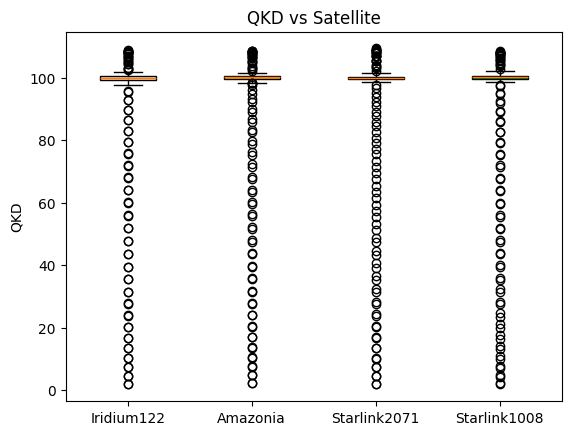

In [ ]:
#box plot
fig, ax = plt.subplots()
bplot = ax.boxplot([qkd_smooth_value_IRIDIUM, qkd_smooth_value_AMAZONIA, qkd_smooth_value_STARLINK, qkd_smooth_value_STARLINK_1008], patch_artist=True)
for patch, color, label in zip(bplot['boxes'], colors, labels):
  patch.set_facecolor(color)
  plt.xticks([1, 2, 3, 4], ['Iridium122', 'Amazonia', 'Starlink2071', 'Starlink1008'])
plt.title('QKD vs Satellite')
plt.ylabel('QKD')